In [12]:
%matplotlib inline

import re
import sqlite3
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

con = sqlite3.connect('main.db')

### Raw Data

In [9]:
project_name = 'cpython'

sql = f'''
select tag, date(creator_dt)
from projects join releases on projects.id = releases.project_id
where name = '{project_name}'
'''
raw_releases = con.execute(sql).fetchall()
print(f'raw: {raw_releases[:5] + raw_releases[-5:]}')
print(f'- len {len(raw_releases)}')



raw: [('2.0', '2017-06-19'), ('2.1', '2017-06-19'), ('2.2', '2017-06-19'), ('2.3', '2017-06-19'), ('2.4', '2017-06-19'), ('v3.9.5', '2021-05-03'), ('v3.9.6', '2021-06-28'), ('v3.9.7', '2021-08-30'), ('v3.9.8', '2021-11-05'), ('v3.9.9', '2021-11-15')]
- len 492


### Plottable Releases

In [26]:
minor_pat = re.compile(r'^[0-9]+\.[0-9]+$')
def parse(raw):
    rel, date = raw
    rel = rel.lstrip('v')
    if minor_pat.match(rel):
        return (rel, date)
    else:
        # print(f'?? {rel=}')
        return None

releases = list(filter(None, map(parse, raw_releases)))
for rel in releases[:5] + releases[-5:]:
    print(rel[0], minor_pat.match(rel[0]))


2.0 <re.Match object; span=(0, 3), match='2.0'>
2.1 <re.Match object; span=(0, 3), match='2.1'>
2.2 <re.Match object; span=(0, 3), match='2.2'>
2.3 <re.Match object; span=(0, 3), match='2.3'>
2.4 <re.Match object; span=(0, 3), match='2.4'>
2.6 <re.Match object; span=(0, 3), match='2.6'>
2.7 <re.Match object; span=(0, 3), match='2.7'>
3.0 <re.Match object; span=(0, 3), match='3.0'>
3.1 <re.Match object; span=(0, 3), match='3.1'>
3.2 <re.Match object; span=(0, 3), match='3.2'>


In [27]:
names = [row[0] for row in releases]
dates = [row[1] for row in releases]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
print(dates[:3])

[datetime.datetime(2017, 6, 19, 0, 0), datetime.datetime(2017, 6, 19, 0, 0), datetime.datetime(2017, 6, 19, 0, 0)]


[(datetime.datetime(2017, 6, 19, 0, 0), -5, '2.0'), (datetime.datetime(2017, 6, 19, 0, 0), 5, '2.1'), (datetime.datetime(2017, 6, 19, 0, 0), -3, '2.2')]


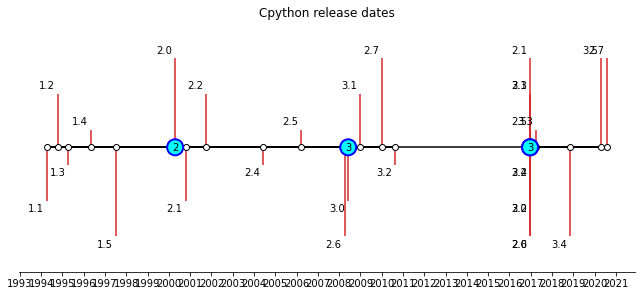

<Figure size 432x288 with 0 Axes>

In [31]:
# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)

# TODO: red lines on minor only
ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="black", markerfacecolor="white")  # Baseline and markers on it.

releases = list(zip(dates, levels, names))
print(releases[:3])

min_style = dict(textcoords="offset points",
                horizontalalignment="right")
major_style = dict(
        size=10, ha="center", va="center", # rotation=45, 
        bbox=dict(boxstyle="circle,pad=0.3", fc="cyan", ec="b", lw=2)
)

# annotate minor releases
for a_date, a_level, name in releases:
        # if is_minor(name):
        #         label = name[:-2]  # "major.minor"
        # else:
        #         continue
        label = name
        ax.annotate(label, xy=(a_date, a_level),
                xytext=(-3, np.sign(a_level)*3),
                verticalalignment="bottom" if a_level > 0 else "top",
                **min_style)

# major releases get big blue circle
major_pat = re.compile(r'([0-9]+)\.0')
for a_date, a_level, name in releases:
        match = major_pat.match(name)
        if not match:
                continue
        label = match.group(1)  # "major" (no minor nor micro)
        ax.text(a_date, 0, label, **major_style)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set(title=f"{project_name.title()} release dates")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.2)

plt.show()

plt.savefig(f"{project_name}-releases.png")